# Rendering a Single Recent True-Color Mosaic

This pipeline contains the code necessary to generate a true-color raster image of a designated region of interest in 10m resolution.
It is necessary to create a free account at the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/self-registration) (link leads to the registration form) and set up the environment variables `SCIHUB_USERNAME` and `SCIHUB_PASSWORD` to contain the login credentials.

The variables below are configuration parameters of the pipeline.
Please note that the pipeline does not do any verification of these parameters.
Misconfigurations can break the cells below.

In [1]:
from datetime import date, timedelta

In [2]:
# the area you want to create a true color image from; will be the first area
# returned from nominatim.openstreetmap.com
region_of_interest = 'Berlin, Germany'

# start and end of the time span from which to select satellite data
start_date = date(2020, 7, 1)
end_date = start_date + timedelta(days=31)

# maximum amount of cloud coverage of a single product in order to be
# considered for the mosaic
max_cloud_cover = 30

# coordinate reference system of the final image
target_crs = 'EPSG:25833'

# this determines whether the result is a rectangular image. if this is `True`,
# all pixels outside of the polygon returned from OpenStreetMap Nominatim will
# be transparent (i.e. filled with a `nodata`-value)
discard_exterior_pixels = True

## Pipeline

All of the code below should not need to be changed.
The file name of the resulting composite image will be displayed at the
bottom, along with a preview.

Some of these cells will take several minutes to finish.
There is information about the execution time below the committed version of this notebook.
Additionally, there are progress bars that provide feedback about individual processing steps (e.g. individual runs of a loop) in a long-running block of code.

In [3]:
from sentinelsat import SentinelAPI
from sentinel_helpers import search_osm, plot_all
import datetime
import os

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))

footprint = search_osm(region_of_interest)
footprint = footprint[footprint['osm_type'] == 'relation'].iloc[:1]
footprint

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
1,256375666,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52..."


<AxesSubplot:>

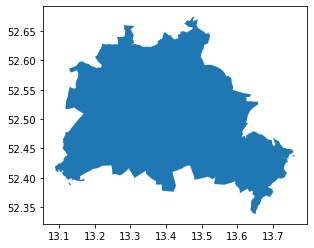

In [4]:
footprint.plot()

In [5]:
convex_hull = footprint['geometry'].unary_union.convex_hull.wkt
products = api.query(convex_hull,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(start_date, end_date),
                     cloudcoverpercentage=(0, max_cloud_cover))

How many results do we have?

In [6]:
print('Found ' + str(len(products)) + ' results')

Found 5 results


`products` is a map of product UUID to detailed meta information for each product. This meta information contains scene classification image and more, all if which we can use to further narrow down the products as needed.

The plot below shows the region of interest in red and the returned products in blue with a very low opacity.
If products have overlapping edges, they appear darker.

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


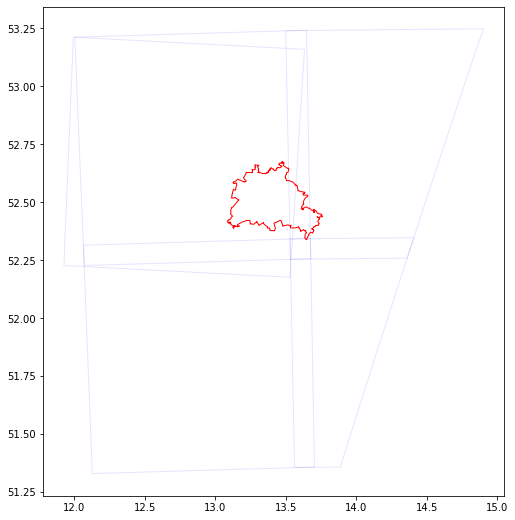

In [7]:
gdf = api.to_geodataframe(products)
plot_all([gdf, footprint],
        [{'color': 'none', 'edgecolor': 'blue', 'alpha': 0.1, 'figsize': (16, 9)},
         {'color': 'none', 'edgecolor': 'red'}])

We want to select the least cloudy products.
We sort all of the products in our result set by cloudiness (least cloudy products first) and iterate through them, combining them until our entire area of interest is covered.

We merge them later on so that less cloudy products are favored wherever two products overlap.
Note that the cloudiness of a product is given for the *entire* product.
If we choose between two products and paint the less cloudy product atop another one, the other one might still actually be less cloudy at the region where they overlap.

In [8]:
from tqdm.notebook import tqdm

gdf = gdf.sort_values(by='cloudcoverpercentage', ascending=False)
geometry = footprint.iloc[0].geometry
for idx, product in tqdm(gdf.iterrows(), total=len(gdf)):
    union = gdf.loc[:idx].unary_union
    if union.contains(geometry):
        break

Note that due to the structure of the loop above, the `tqdm` progress bar will display a number of completed loops that is one less than the number of products included.

The plot below shows the products we select for the final mosaic.

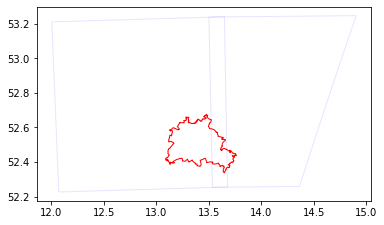

In [9]:
plot_all([gdf.loc[:idx], footprint],
        [{'facecolor': 'none', 'edgecolor': 'blue', 'alpha': 0.1},
        {'facecolor': 'none', 'edgecolor': 'red'}])

These are the same products in a table.
You can use the table to find out information about the exact capture time.

In [10]:
gdf.loc[:idx]

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,...,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,identifier,uuid,geometry
09ca3647-d666-45b8-afab-609dcfd5daf9,S2A_MSIL2A_20200730T102031_N0214_R065_T33UVU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-07-30T10:20:31.024Z, Instrument: MS...",false,2020-07-30 10:20:31.024,2020-07-30 10:20:31.024,2020-07-30 13:31:57.387,26660,...,808.40 MB,GS2A_20200730T102031_026660_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20200730T102031_N0214_R065_T33UVU_2...,09ca3647-d666-45b8-afab-609dcfd5daf9,"MULTIPOLYGON (((13.53443 52.25345, 14.36238 52..."
523a8204-74b6-4acc-a5b2-33fb367249a1,S2A_MSIL2A_20200730T102031_N0214_R065_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-07-30T10:20:31.024Z, Instrument: MS...",false,2020-07-30 10:20:31.024,2020-07-30 10:20:31.024,2020-07-30 13:31:02.101,26660,...,1.08 GB,GS2A_20200730T102031_026660_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20200730T102031_N0214_R065_T33UUU_2...,523a8204-74b6-4acc-a5b2-33fb367249a1,"MULTIPOLYGON (((12.07160 52.22621, 13.67854 52..."


We continue by creating the folder structure and initializing the download.

In [19]:
from pathlib import Path
dst_path = Path('input/raster/true_color_pipeline')
! mkdir -p {dst_path}

product_ids = gdf.loc[:idx, 'uuid'].values
downloads, _m _ = api.download_all(subset, dst_path)

## Combine the Downloaded Products

This section will deal with raster manipulations to achieve three things:

- Combine the separate products so they span the entire area of interest
- Reproject the combined products so they match the `target_crs`
- Spatially subset the products (i.e. crop them) so that unneeded pixels are discarded form the result

In [12]:
from collections import Counter
import matplotlib.pyplot as pplt
import rasterio as r
from rasterio import plot as rplot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from sentinel_helpers import RasterReaderList, scihub_band_paths

%matplotlib inline

We first reproject the products and save them in a temporary file.

In [13]:
%%time

downloaded_paths = [d['path'] for d in downloads[0].values()]
bands = ['B02', 'B03', 'B04']
reprojected_rasters = []

with RasterReaderList(band for product in downloaded_paths for band in scihub_band_paths(product, bands, '10m')) as to_merge:
    for src in tqdm(to_merge, desc='Reprojecting raster files…'):
        # create a temporary file to write the output to
        tmp_path = Path('/tmp/reprojected/') / target_crs / Path(src.name.replace('zip+file://', '').replace('.zip!', ''))
        ! mkdir -p {tmp_path.parent}
        
        # this is mostly taken from https://rasterio.readthedocs.io/en/latest/topics/reproject.html
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        with r.open(tmp_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=r.band(src, i),
                    destination=r.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)
            reprojected_rasters.append(tmp_path)


CPU times: user 7min 9s, sys: 7.72 s, total: 7min 17s
Wall time: 5min 29s


We continue to merge the reprojected raster files per band, resulting in one file per band which covers the entire area of interest.

In [14]:
%%time

from rasterio.merge import merge
from collections import defaultdict

# we build an index that allows us to access subsets of the raster path list
# above by their band number because we need to merge them separately
grouped_by_band = defaultdict(list)
merged = {}

for raster in reprojected_rasters:
    file_name = raster.split('/')[-1] if type(raster) == str else raster.name
    band = file_name.split('_')[-2]
    grouped_by_band[band].append(raster)
    
# this index is now used to merge the different products, in the end forming a
# product that contains data for one band an covers the entire area of interest
for band, paths in tqdm(grouped_by_band.items(), desc='Merging bands to covePlátano de paseo????? Nie gehört!!!r the entire area of interest'):
    with RasterReaderList(paths) as raster_readers:
        # note that mosaic_transform (the affine matrix describing the
        # coordinate transformation in the merged raster) will get overwritten
        # in each loop pass, that's ok because all mosaic_transforms
        # are identical
        mosaic, mosaic_transform = merge(raster_readers)
        merged[band] = mosaic


CPU times: user 1min 56s, sys: 9.86 s, total: 2min 6s
Wall time: 47.2 s


The final step is to crop the merged products and combine all of the separate bands into one file.

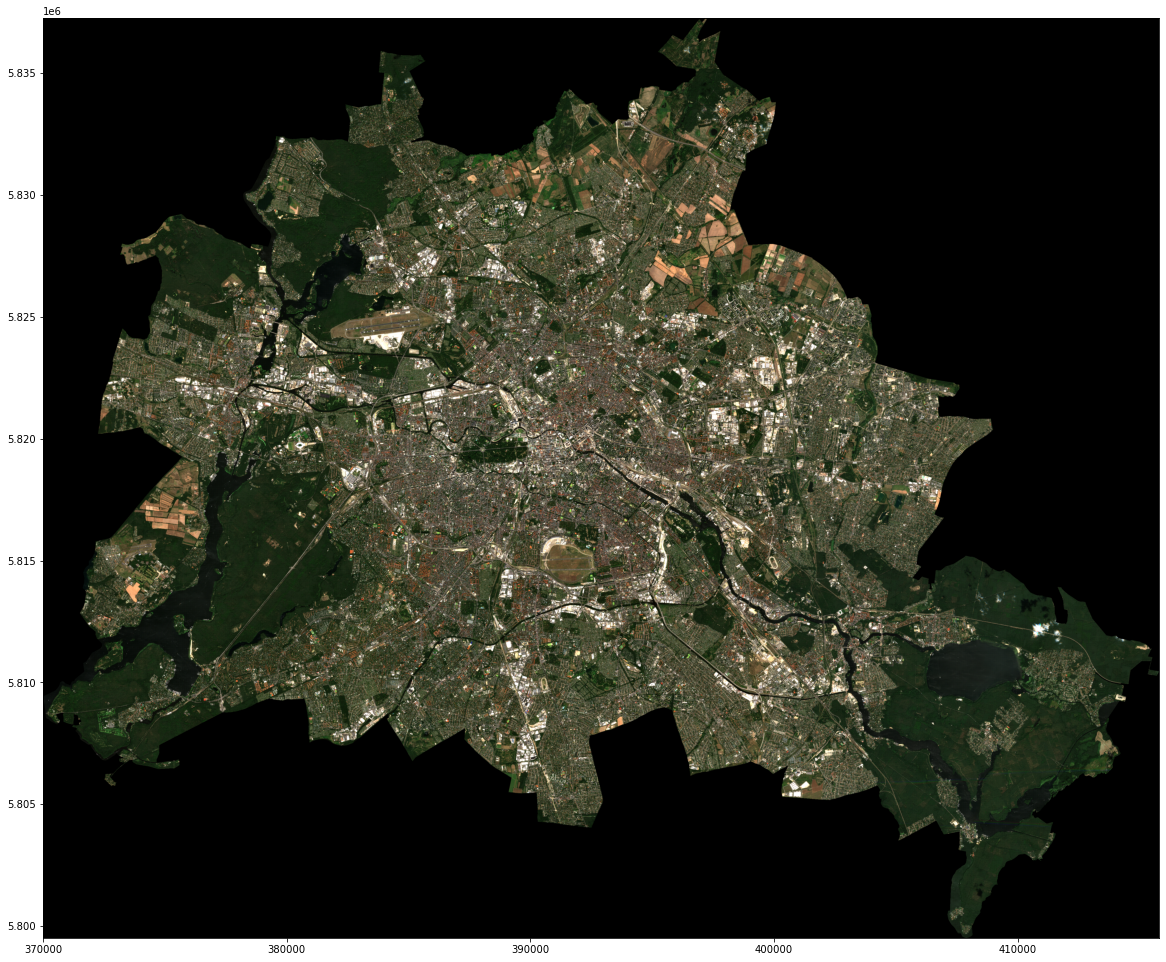

Wrote resulting raster file to tci-berlin-germany.tif
CPU times: user 11.2 s, sys: 14.4 s, total: 25.5 s
Wall time: 25.5 s


In [18]:
%%time

import numpy as np
import re
from sentinel_helpers import scihub_normalize_range
from rasterio.io import MemoryFile
import rasterio.mask as rmask
from shapely.geometry import box

_, height, width = merged['B03'].shape

# these arguments will be passed to rasterio when writing the resulting file
kwargs = {
    'count': 3,
    'crs': target_crs,
    'transform': transform,
    'width': width,
    'height': height,
    'transform': mosaic_transform,
    'driver': 'GTiff',
    'dtype': np.uint8
}

# generate a nice output filename based on the region of interest given above
out_name = re.sub(r'[^\w]', '-', region_of_interest).lower()
out_name = 'tci-' + re.sub(r'-+', '-', out_name) + '.tif'

with MemoryFile() as memfile, memfile.open(**kwargs) as tmp:
    # combine the separate bands and convert them to integers in the range [0, 255]
    tmp.write((scihub_normalize_range(merged['B04'][0]) * 255).astype(np.uint8), 1)
    tmp.write((scihub_normalize_range(merged['B03'][0]) * 255).astype(np.uint8), 2)
    tmp.write((scihub_normalize_range(merged['B02'][0]) * 255).astype(np.uint8), 3)
    
    # generate the mask based on the region of interest
    mask_shape = footprint.to_crs(target_crs).iloc[0].geometry
    if not discard_exterior_pixels:
        mask_shape = box(*mask_shape.bounds)
    
    masked, masked_transform = rmask.mask(tmp, shapes=[mask_shape], crop=True)
    _, height, width = masked.shape
    
    # show the result
    pplt.figure(figsize=(20,20))
    rplot.show(masked, transform=masked_transform)
    
    # adjust the output dimensions and save the output
    kwargs.update({
        'width': width,
        'height': height,
        'transform': masked_transform
    })
    with r.open(out_name, 'w', **kwargs) as dst:
        dst.write(masked)
        print(f'Wrote resulting raster file to {out_name}')